# Finance-Datareader 데이터셋

* 환율,외국증시정보,국내주식 거래량,종가,변화율 정보 가져오기 가능
* 절대 변화량 정보는 제공되지 않아 계산으로 구해야 함.

### 거래 정지를 당한 종목 가져오기
* 거래 정지를 당한 종목은 분석을 하는데에 있어서 큰 의미가 없음.
* 오히려 편차를 키우고 데이터의 오류를 증가시킬 수 있으므로 제외를 해 주는 것이 좋음.
* 다른 사이트의 데이터를 크롤링하여 거래정지당한 종목 번호를 가져옴.

In [ ]:
from bs4 import BeautifulSoup
import requests
import sys
import math

기준 사이트
* https://www.kokstock.com/stock/halt.asp?page=(페이지 숫자)
* 페이지 최대 숫자는 반드시 지정해 주어야 함. 거래정지된 종목 갯수에 따라 달라진다. 20개 단위로 표시되므로 올림 함수를 사용해야 함.

In [ ]:
pagenum=1
halteditemcode=[]
maxpagenum=0
while True:
    url=f'https://www.kokstock.com/stock/halt.asp?page={pagenum}'
    header={"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"}
    res=requests.get(url,headers=header)
    soup=BeautifulSoup(res.text)
    pagedata=soup.find('b',{"id":"searchTotal"})
    maxpagenum=math.ceil(int(pagedata.text)/20)#불러오기 최소화를 위하여 이 형태로 최대 페이지를 지정함.
    data=soup.findAll('span',{'title':"더블클릭시 클립보드에 복사됩니다"})
    for items in data:
        halteditemcode.append(items.text)
    if (pagenum<maxpagenum):
        pagenum+=1
    else:
        pagenum=1
        break
print(halteditemcode)


['001529', '009275', '016385', '344050', '002270', '005010', '054180', '284620', '388790', '138690', '342550', '096640', '341160', '030790', '397500', '367460', '335870', '332710', '331520', '333050', '068330', '318020', '136510', '019490', '181340', '269620', '052420', '097780', '226440', '057880', '219750', '148140', '032860', '007610', '114120', '150840', '078650', '012200', '012205', '215090', '299910', '050540', '091970', '090740', '053110', '064510', '115180', '208860', '038340', '012600', '015540', '099520', '126870', '182690', '069110', '078590', '033340', '178780', '065560', '103230', '006580', '101680', '058420', '127160', '056000', '016670', '003620', '257370', '058530', '009730', '263920', '215600', '223310', '109070', '010580', '263540', '160600', '121890', '058220', '158310', '141020', '900100', '033790', '032790', '024830', '021820', '060300', '950160', '138360', '180400', '054220', '056730', '083470', '052770', '064520', '106080']


### 필요한 기본 계수 설정

* 아래 데이터 프레임을 정리하기 위하여 반드시 값을 넣어야 한다.
* 만약 값에 거래정지된 종목이 있는 경우 오류를 발생시키고 모든 실행을 강제 중지시킴.

In [ ]:
class HaltedItemcodeError(Exception):
    def __init__(self,itemcode):
        self.itemcode=itemcode
    def __str__(self):
        return f"{self.itemcode}: 거래 정지가 된 종목입니다."      
class InvalidItemcodeError(Exception):
    def __init__(self,itemcode):
        self.itemcode=itemcode
    def __str__(self):
        return f"{self.itemcode}: 종목 번호가 잘못되었습니다. 종목 번호는 반드시 6자리의 숫자여야 합니다."
class WrongUSCodeError(Exception):
    def __init__(self,itemcode):
        self.itemcode=itemcode
    def __str__(self):
        return f"{self.itemcode}: 잘못된 종합지수 검색 코드입니다. 미국 종합지수 코드는 <DJI,IXIC,US500,VIX> 넷 중 하나만 사용할 수 있습니다."
    

In [ ]:
#시작값과 끝값 지정 시 모든 데이터 프레임을 그 년도로 지정한다.
#end값에는 0이 들어갈 경우 현재까지 출력이 나오도록 고정한다.
#잘못된 값을 넣을 경우 강제 종료하도록 설정한다.
start=2007#시작 일자
end=0#끝 일자
Domidx="005930"#국내주식 종목 번호-반드시 6자리 숫자여야 함.
USidx="IXIC"#해외주식 지수 고유값
Curidx="USD/KRW"#환율:기준 환율(1)/변환 환율(여러 값이 나올 수 있음.)

In [ ]:
#값의 무결성 검사-국내주식 종목
ValidUSidx=["VIX","IXIC","DJI","US500"]
for numbers in Domidx:
    try:
        _=int(numbers)#번호에 문자가 포함되어 있지 않은지 확인
        if(len(Domidx)!=6):#종목번호가 6자리인지 확인
            raise InvalidItemcodeError(Domidx)#6자리가 아닐 경우 오류메시지를 출력하고 강제 종료
    except ValueError:#내부에 문자가 단 한개라도 포함되었을 경우 오류메시지 출력
        raise InvalidItemcodeError(Domidx)
    if Domidx in halteditemcode:#Domidx(국내주식 종목번호)에 거래정지된 주식이 포함되어있을 경우
        raise HaltedItemcodeError(Domidx)
#값의 무결성 검사-미국주가지수 지표
if USidx not in ValidUSidx:
    raise WrongUSCodeError(USidx)


In [ ]:
if(end==0):
    end=None
else:
    end=str(end)
start=str(start)


### 국내시장 데이터 가져오기

* 입력 데이터:미국 증시(NASDAQ), 환율, 거래량
* 출력 데이터:종가 정보, 기준선에서의 변화율,기준선에서의 절대변화량
* 일반 데이터:다른 정보
* 만약 거래 정지 종목 또는 관리 종목이 있을 경우, 그 데이터는 전부 제외해야 함. 거래 정지된 종목이 포함되었을 경우 모델에 심각한 오류가 발생할 수 있음.

In [ ]:
from FinanceDataReader import *
import pandas as pd

데이터리더 기본 함수

* fdr.DataReader(일반값,시작일자,종료일자)
* 일반값-(6자리 숫자로만 이루어진 코드):국내주식 정보 불러오기
* 일반값-(3자리 환율코드-3자리 환율코드):환율 정보 불러오기
* 일반값-(지수 코드):국내,해외주식 지수 정보 불러오기
* 시작 일자:검색 시작 일자.반드시 들어가야 하나 값이 상장된 시점보다 이른 경우 그 주식이 상장된 시점부터 불러오기 시작함.
* 종료 일자:검색 종료 일자. 없을 경우 현재까지의 시점을 불러옴.
> 데이터리더 계열 함수에서 제대로 된 데이터를 가져오기 위해서는 읽어오는 시간 간격(시작-종료 일자)가 동일해야 한다. 다른 경우 아래의 데이터 전처리 과정에서 심각한 데이터 왜곡이 발생할 수 있음.

In [ ]:
dom_df=DataReader(Domidx,start,end)#데이터가 없을 경우 그 전 데이터를 가져옴.
dom_df.info()#Null 체크
dom_df=dom_df.reset_index()
dom_df


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3833 entries, 2007-01-02 to 2022-07-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3833 non-null   int64  
 1   High    3833 non-null   int64  
 2   Low     3833 non-null   int64  
 3   Close   3833 non-null   int64  
 4   Volume  3833 non-null   int64  
 5   Change  3833 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 209.6 KB


,Date,Open,High,Low,Close,Volume,Change
0,2007-01-02,12400,12540,12320,12500,355265,0.019576
1,2007-01-03,12540,12560,12220,12220,394730,-0.022400
2,2007-01-04,12220,12240,12060,12140,381464,-0.006547
3,2007-01-05,12160,12180,11900,11900,586649,-0.019769
4,2007-01-08,11840,11880,11580,11640,682494,-0.021849
...,...,...,...,...,...,...,...
3828,2022-06-29,58500,58800,58000,58000,14677138,-0.023569
3829,2022-06-30,57200,57600,57000,57000,18915142,-0.017241
3830,2022-07-01,56900,57500,55900,56200,24982097,-0.014035
3831,2022-07-04,56100,57400,55700,57100,17807126,0.016014


### 미국 증시 데이터 가져오기
* 사용될 값을 변화량,변화율과 장마감 지수 상태로 지정

In [ ]:
df=DataReader(USidx,start,end).reset_index()
Tick=True

In [ ]:
USI_df=pd.DataFrame(columns=["Date","I-Close","I-Change"])

USI_df["Date"]=df["Date"]
USI_df["I-Close"]=df["Close"]
USI_df["I-Change"]=df["Change"]
USI_df

,Date,I-Close,I-Change
0,2007-01-03,2423.16,0.0033
1,2007-01-04,2453.43,0.0125
2,2007-01-05,2434.25,-0.0078
3,2007-01-08,2438.20,0.0016
4,2007-01-09,2443.83,0.0023
...,...,...,...
3897,2022-06-27,11524.55,-0.0072
3898,2022-06-28,11181.54,-0.0298
3899,2022-06-29,11177.89,-0.0003
3900,2022-06-30,11028.74,-0.0133


### 환율 정보 가져오기
* 사용될 값을 변화율과 장마감 환율,변화량으로 설정

In [ ]:
read_df=DataReader(Curidx,start,end).reset_index()
cur_df=pd.DataFrame(columns=["Date","C-Close","C-Change"])
cur_df[["Date","C-Close","C-Change"]]=read_df[["Date","Close","Change"]]
cur_df

,Date,C-Close,C-Change
0,2007-01-01,930.00,0.0000
1,2007-01-02,925.65,-0.0047
2,2007-01-03,926.15,0.0005
3,2007-01-04,931.35,0.0056
4,2007-01-05,934.45,0.0033
...,...,...,...
4043,2022-06-30,1287.51,-0.0111
4044,2022-07-01,1298.67,0.0087
4045,2022-07-03,1298.89,0.0002
4046,2022-07-04,1295.95,-0.0023


### 전체 데이터 정리+ 결측값 없애기
* 미국 증시와 환율. 한국 증시는 여는 날이 다르므로 결측값이 반드시 발생함.
* 합치는 것은 일자를 기준으로 수행해야 하나, 데이터의 손실이 있어서는 안 되므로 전부 포함되도록 재설정해야 함.
* 휴장하는 날에 가격 데이터는 전 날 데이터로 처리해야 함. 변동이 없기 때문이다.
* 가격 변동성 데이터,거래량 데이터는 휴장하는 날에는 모두 0으로 처리해야 함.
* 단, 이 데이터 프레임으로 알 수 없는 데이터(전날 데이터를 알 수 없는 값)은 그 뒷값으로 채워, 약간의 오차가 발생할 수 있음.

In [ ]:
Total_df=pd.merge(dom_df,cur_df,on="Date")
Total_df=pd.merge(Total_df,USI_df,on="Date")
tick=True
Total_df.tail(10)

,Date,Open,High,Low,Close,Volume,Change,C-Close,C-Change,I-Close,I-Change
3705,2022-06-17,59400,59900,59400,59800,29053450,-0.018062,1291.26,0.0024,10798.35,0.0143
3706,2022-06-21,58700,59200,58200,58500,25148109,-0.003407,1291.72,0.0001,11069.30,0.0251
3707,2022-06-22,59000,59100,57600,57600,23334687,-0.015385,1297.58,0.0045,11053.08,-0.0015
3708,2022-06-23,57700,58000,56800,57400,28338608,-0.003472,1299.81,0.0017,11232.19,0.0162
3709,2022-06-24,57900,59100,57700,58400,23256103,0.017422,1288.89,-0.0084,11607.62,0.0334
3710,2022-06-27,59000,59900,58300,58800,18122236,0.006849,1286.31,-0.0020,11524.55,-0.0072
3711,2022-06-28,59200,59500,58700,59400,13540538,0.010204,1292.06,0.0045,11181.54,-0.0298
3712,2022-06-29,58500,58800,58000,58000,14677138,-0.023569,1301.90,0.0076,11177.89,-0.0003
3713,2022-06-30,57200,57600,57000,57000,18915142,-0.017241,1287.51,-0.0111,11028.74,-0.0133
3714,2022-07-01,56900,57500,55900,56200,24982097,-0.014035,1298.67,0.0087,11127.84,0.0090


In [ ]:
#전날 값 불러오기 및 정리
if tick:
    yd_data=Total_df['Close']
    yc_data=Total_df["C-Close"]
    yi_data=Total_df["I-Close"]
    yd_data.loc[-1]=Total_df["Close"].iloc[0]-(Total_df["Close"].iloc[0]*Total_df["Change"].iloc[0])/(1-Total_df["Change"].iloc[0])
    yc_data.loc[-1]=Total_df["C-Close"].iloc[0]-(Total_df["C-Close"].iloc[0]*Total_df["C-Change"].iloc[0])/(1-Total_df["C-Change"].iloc[0])
    yi_data.loc[-1]=Total_df["I-Close"].iloc[0]-(Total_df["I-Close"].iloc[0]*Total_df["I-Change"].iloc[0])/(1-Total_df["I-Change"].iloc[0])
    #첫 번째 변화량은 연산이 불가능하므로 주어진 데이터를 통하여 역산하여 추측함.
    yd_data.index=yd_data.index+1
    yc_data.index=yc_data.index+1
    yi_data.index=yi_data.index+1
    yd_data=yd_data.sort_index()
    yc_data=yc_data.sort_index()
    yi_data=yi_data.sort_index()
    yd_data=yd_data.drop(index=len(yd_data)-1,axis=0)
    yc_data=yc_data.drop(index=len(yc_data)-1,axis=0)
    yi_data=yi_data.drop(index=len(yi_data)-1,axis=0)
    Total_df=Total_df.assign(Yd_close=yd_data)
    Total_df=Total_df.assign(Yc_close=yc_data)
    Total_df=Total_df.assign(Yi_close=yi_data)
    Total_df["Difference"]=Total_df["Close"]-Total_df["Yd_close"]
    Total_df["C-Difference"]=Total_df["C-Close"]-Total_df["Yc_close"]
    Total_df["I-Difference"]=Total_df["I-Close"]-Total_df["Yi_close"]
    Total_df["Change"]=Total_df["Difference"]/Total_df["Yd_close"]*100
    Total_df["C-Change"]=Total_df["C-Difference"]/Total_df["Yc_close"]*100
    Total_df["I-Change"]=Total_df["I-Difference"]/Total_df["Yi_close"]*100
    Total_df=Total_df.drop(labels=["Yd_close","Yc_close","Yi_close"],axis=1)
    Total_df["Difference"]=Total_df["Difference"].astype(int)
    Total_df=Total_df[Total_df["Volume"]!=0]#거래량이 0인 부분도 삭제함.
    tick=False
Total_df.info()
Total_df


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712 entries, 0 to 3714
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3712 non-null   datetime64[ns]
 1   Open          3712 non-null   int64         
 2   High          3712 non-null   int64         
 3   Low           3712 non-null   int64         
 4   Close         3712 non-null   int64         
 5   Volume        3712 non-null   int64         
 6   Change        3712 non-null   float64       
 7   C-Close       3712 non-null   float64       
 8   C-Change      3712 non-null   float64       
 9   I-Close       3712 non-null   float64       
 10  I-Change      3712 non-null   float64       
 11  Difference    3712 non-null   int32         
 12  C-Difference  3712 non-null   float64       
 13  I-Difference  3712 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int32(1), int64(5)
memory usage: 420.5 KB


,Date,Open,High,Low,Close,Volume,Change,C-Close,C-Change,I-Close,I-Change,Difference,C-Difference,I-Difference
0,2007-01-03,12540,12560,12220,12220,394730,-2.143951,926.15,0.050050,2423.16,0.332192,-267,0.463307,8.022904
1,2007-01-04,12220,12240,12060,12140,381464,-0.654664,931.35,0.561464,2453.43,1.249195,-80,5.200000,30.270000
2,2007-01-05,12160,12180,11900,11900,586649,-1.976936,934.45,0.332850,2434.25,-0.781763,-240,3.100000,-19.180000
3,2007-01-08,11840,11880,11580,11640,682494,-2.184874,938.10,0.390604,2438.20,0.162268,-260,3.650000,3.950000
4,2007-01-09,11740,11880,11640,11720,402197,0.687285,938.60,0.053299,2443.83,0.230908,80,0.500000,5.630000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,2022-06-27,59000,59900,58300,58800,18122236,0.684932,1286.31,-0.200172,11524.55,-0.715651,400,-2.580000,-83.070000
3711,2022-06-28,59200,59500,58700,59400,13540538,1.020408,1292.06,0.447015,11181.54,-2.976342,600,5.750000,-343.010000
3712,2022-06-29,58500,58800,58000,58000,14677138,-2.356902,1301.90,0.761575,11177.89,-0.032643,-1400,9.840000,-3.650000
3713,2022-06-30,57200,57600,57000,57000,18915142,-1.724138,1287.51,-1.105308,11028.74,-1.334331,-1000,-14.390000,-149.150000


### 보조 지표 불러오기

In [ ]:
import ta

In [ ]:
H, L, C, V =Total_df['High'], Total_df['Low'], Total_df['Close'], Total_df['Volume']

In [ ]:
sdf = pd.DataFrame()
sdf['MFI'] = ta.volume.money_flow_index(
    high=H, low=L, close=C, volume=V, fillna=True)

sdf['ADI'] = ta.volume.acc_dist_index(
    high=H, low=L, close=C, volume=V, fillna=True)

sdf['OBV'] = ta.volume.on_balance_volume(close=C, volume=V, fillna=True)
sdf['CMF'] = ta.volume.chaikin_money_flow(
    high=H, low=L, close=C, volume=V, fillna=True)

sdf['FI'] = ta.volume.force_index(close=C, volume=V, fillna=True)
sdf['EOM, EMV'] = ta.volume.ease_of_movement(
    high=H, low=L, volume=V, fillna=True)

sdf['VPT'] = ta.volume.volume_price_trend(close=C, volume=V, fillna=True)
sdf['NVI'] = ta.volume.negative_volume_index(close=C, volume=V, fillna=True)
sdf['VMAP'] = ta.volume.volume_weighted_average_price(
    high=H, low=L, close=C, volume=V, fillna=True)

# Volatility
sdf['ATR'] = ta.volatility.average_true_range(
    high=H, low=L, close=C, fillna=True)
sdf['BHB'] = ta.volatility.bollinger_hband(close=C, fillna=True)
sdf['BLB'] = ta.volatility.bollinger_lband(close=C, fillna=True)
sdf['KCH'] = ta.volatility.keltner_channel_hband(
    high=H, low=L, close=C, fillna=True)
sdf['KCL'] = ta.volatility.keltner_channel_lband(
    high=H, low=L, close=C, fillna=True)
sdf['KCM'] = ta.volatility.keltner_channel_mband(
    high=H, low=L, close=C, fillna=True)
sdf['DCH'] = ta.volatility.donchian_channel_hband(
    high=H, low=L, close=C, fillna=True)
sdf['DCL'] = ta.volatility.donchian_channel_lband(
    high=H, low=L, close=C, fillna=True)
sdf['DCM'] = ta.volatility.donchian_channel_mband(
    high=H, low=L, close=C, fillna=True)
sdf['UI'] = ta.volatility.ulcer_index(close=C, fillna=True)
# Trend
sdf['SMA'] = ta.trend.sma_indicator(close=C, fillna=True)
sdf['EMA'] = ta.trend.ema_indicator(close=C, fillna=True)
sdf['WMA'] = ta.trend.wma_indicator(close=C, fillna=True)
sdf['MACD'] = ta.trend.macd(close=C, fillna=True)
sdf['ADX'] = ta.trend.adx(high=H, low=L, close=C, fillna=True)
sdf['-VI'] = ta.trend.vortex_indicator_neg(
    high=H, low=L, close=C, fillna=True)
sdf['+VI'] = ta.trend.vortex_indicator_pos(
    high=H, low=L, close=C, fillna=True)
sdf['TRIX'] = ta.trend.trix(close=C, fillna=True)
sdf['MI'] = ta.trend.mass_index(high=H, low=L, fillna=True)
sdf['CCI'] = ta.trend.cci(high=H, low=L, close=C, fillna=True)
sdf['DPO'] = ta.trend.dpo(close=C, fillna=True)
sdf['KST'] = ta.trend.kst(close=C, fillna=True)
sdf['Ichimoku'] = ta.trend.ichimoku_a(high=H, low=L, fillna=True)
sdf['Parabolic SAR'] = ta.trend.psar_down(
    high=H, low=L, close=C, fillna=True)
sdf['STC'] = ta.trend.stc(close=C, fillna=True)
# Momentum
sdf['RSI'] = ta.momentum.rsi(close=C, fillna=True)
sdf['SRSI'] = ta.momentum.stochrsi(close=C, fillna=True)
sdf['TSI'] = ta.momentum.tsi(close=C, fillna=True)
sdf['UO'] = ta.momentum.ultimate_oscillator(
    high=H, low=L, close=C, fillna=True)
sdf['SR'] = ta.momentum.stoch(close=C, high=H, low=L, fillna=True)
sdf['WR'] = ta.momentum.williams_r(high=H, low=L, close=C, fillna=True)
sdf['AO'] = ta.momentum.awesome_oscillator(high=H, low=L, fillna=True)
sdf['KAMA'] = ta.momentum.kama(close=C, fillna=True)
sdf['ROC'] = ta.momentum.roc(close=C, fillna=True)
sdf['PPO'] = ta.momentum.ppo(close=C, fillna=True)
sdf['PVO'] = ta.momentum.pvo(volume=V, fillna=True)
sdf['BOL_H'] = ta.volatility.bollinger_hband(close=C, fillna=True)
sdf['BOL_L'] = ta.volatility.bollinger_lband(close=C, fillna=True)


In [ ]:
sdf=sdf.fillna(0)
sdf.info()
sdf
tick=True

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712 entries, 0 to 3714
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MFI     3712 non-null   float64
 1   ADI     3712 non-null   float64
 2   OBV     3712 non-null   int64  
 3   MACD    3712 non-null   float64
 4   CCI     3712 non-null   float64
 5   RSI     3712 non-null   float64
 6   BOL_H   3712 non-null   float64
 7   BOL_L   3712 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 261.0 KB


### 모든 값 정리

In [ ]:
if tick:
    new_total=pd.concat([Total_df,sdf],axis=1)
    new_total=new_total.set_index("Date",drop=True).sort_index()
    tick=False


### 이동평균선 데이터 추가
* 이동평균선은 과거의 데이터를 기반으로 작성되기 때문에 첫 4일치 데이터는 작성되지 않음(5, 20, 60, 120일 기준으로 작성)

In [ ]:
ma = [5,20,60,120]
for days in ma:
    new_total['ma_'+str(days)] = new_total['Close'].rolling(window = days).mean().round()

new_total

,Open,High,Low,Close,Volume,Change,C-Close,C-Change,I-Close,I-Change,...,OBV,MACD,CCI,RSI,BOL_H,BOL_L,ma_5,ma_20,ma_60,ma_120
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,12540,12560,12220,12220,394730,-2.143951,926.15,0.050050,2423.16,0.332192,...,394730,0.000000,0.000000,100.000000,12220.000000,12220.000000,NaN,NaN,NaN,NaN
2007-01-04,12220,12240,12060,12140,381464,-0.654664,931.35,0.561464,2453.43,1.249195,...,13266,-6.381766,-66.666667,0.000000,12260.000000,12100.000000,NaN,NaN,NaN,NaN
2007-01-05,12160,12180,11900,11900,586649,-1.976936,934.45,0.332850,2434.25,-0.781763,...,-573383,-30.454298,-93.670886,0.000000,12358.614374,11814.718959,NaN,NaN,NaN,NaN
2007-01-08,11840,11880,11580,11640,682494,-2.184874,938.10,0.390604,2438.20,0.162268,...,-1255877,-69.708227,-116.384181,0.000000,12427.879675,11522.120325,NaN,NaN,NaN,NaN
2007-01-09,11740,11880,11640,11720,402197,0.687285,938.60,0.053299,2443.83,0.230908,...,-853680,-93.286568,-75.873828,13.503937,12377.537209,11470.462791,11924.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,59000,59900,58300,58800,18122236,0.684932,1286.31,-0.200172,11524.55,-0.715651,...,379583812,-2318.585581,-81.818182,28.974956,69669.005734,55890.994266,58140.0,62780.0,65895.0,70112.0
2022-06-28,59200,59500,58700,59400,13540538,1.020408,1292.06,0.447015,11181.54,-2.976342,...,393124350,-2218.661729,-70.640177,33.251010,69258.791987,55601.208013,58320.0,62430.0,65723.0,69956.0
2022-06-29,58500,58800,58000,58000,14677138,-2.356902,1301.90,0.761575,11177.89,-0.032643,...,378447212,-2226.770828,-82.892987,28.881673,68928.845081,55141.154919,58400.0,62035.0,65520.0,69778.0


### 데이터 정규화

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# 가격 정규화
scaler = MinMaxScaler()
scale_price = ["Close", "I-Close", "C-Close"]
p_scaled = scaler.fit_transform(new_total[scale_price])
p_scaled = pd.DataFrame(p_scaled)
p_scaled.columns = scale_price


In [ ]:
p_scaled.index = pd.to_datetime(new_total.index)
p_scaled.head()

,Close,I-Close,C-Close
Date,,,
2007-01-03,0.049125,0.078067,0.037844
2007-01-04,0.048159,0.080114,0.045607
2007-01-05,0.045263,0.078817,0.050235
2007-01-08,0.042124,0.079084,0.055684
2007-01-09,0.043090,0.079465,0.056431


<AxesSubplot:xlabel='Date'>

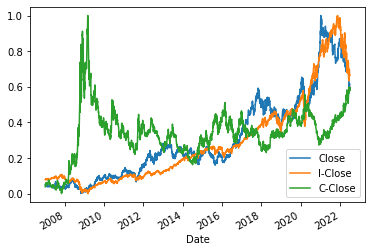

In [ ]:
p_scaled.plot()

In [ ]:
# 보조지표 정규화

scaler = MinMaxScaler()
scale_indicator = ["MACD", "BOL_H", "BOL_L","ma_5", "ma_20", "ma_60", "ma_120"]
i_scaled = scaler.fit_transform(new_total[scale_indicator])
i_scaled = pd.DataFrame(i_scaled)
i_scaled.columns = scale_indicator

In [ ]:
i_scaled.index = pd.to_datetime(new_total.index)

In [ ]:
i_scaled.tail(30)

,MACD,BOL_H,BOL_L,ma_5,ma_20,ma_60,ma_120
Date,,,,,,,
2022-05-17,0.343500,0.686886,0.771664,0.707562,0.741174,0.800051,0.858238
2022-05-18,0.362301,0.688443,0.770944,0.713470,0.741690,0.798563,0.857854
2022-05-19,0.372207,0.688602,0.770895,0.719870,0.741754,0.796887,0.857415
2022-05-20,0.384799,0.689211,0.770595,0.723562,0.741948,0.795480,0.857113
2022-05-23,0.394025,0.690570,0.770242,0.727501,0.742528,0.794246,0.856853
2022-05-24,0.388961,0.690629,0.770445,0.724793,0.742657,0.792798,0.856318
2022-05-25,0.384306,0.690663,0.770815,0.720609,0.742851,0.791659,0.855345
2022-05-26,0.376472,0.689895,0.772937,0.716670,0.743431,0.790318,0.854262
2022-05-27,0.376005,0.688526,0.776848,0.712978,0.744527,0.789058,0.853316
